In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit  # aka logistic

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import sinvchi2
import plot_tools

In [3]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

## Model with unknown mean and variance

In [4]:
# data
y = np.array([93, 112, 122, 135, 122, 150, 118, 90, 124, 114])
# sufficient statistics
n = len(y)
s2 = np.var(y, ddof=1)  # here ddof=1 is used to get the sample estimate
my = np.mean(y)

In [5]:
# set random number generator with seed
rng = np.random.RandomState(seed=0)

#### Sampling

In [6]:
# factorize the joint posterior p(mu,sigma2|y) to p(sigma2|y)p(mu|sigma2,y)
# sample from the joint posterior using this factorization

# sample from p(sigma2|y)
sigma2 = sinvchi2.rvs(n-1, s2, size=10000, random_state=rng)
# sample from p(mu|sigma2,y) 
mu = my + np.sqrt(sigma2/n)*rng.randn(*sigma2.shape)
# display sigma instead of sigma2
sigma = np.sqrt(sigma2)
# sample from the predictive distribution p(ynew|y)
# for each sample of (mu, sigma)
ynew = rng.randn(*mu.shape)*sigma + mu

Text(0.5, 1.0, 'p(sigma2|y)')

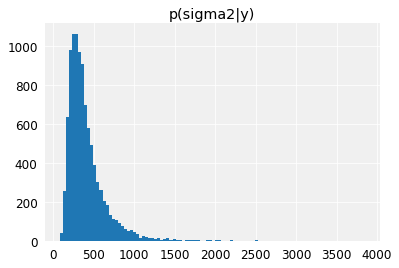

In [7]:
_=plt.hist(sigma2, bins=100)
plt.title('p(sigma2|y)')

Text(0.5, 1.0, 'p(sigma|y)')

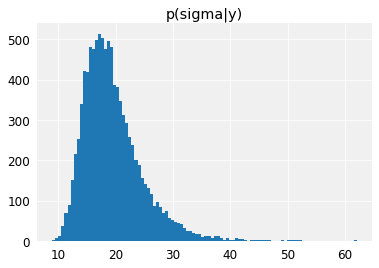

In [8]:
_=plt.hist(sigma, bins=100)
plt.title('p(sigma|y)')

Text(0.5, 1.0, 'predictive distribution - p(mu|sigma2,y)')

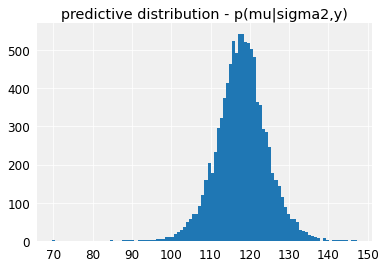

In [9]:
_=plt.hist(mu, bins=100)
plt.title('predictive distribution - p(mu|sigma2,y)')

#### exact calculation

In [10]:
#exact calculation for mu
tl1 = [90, 150]
t1 = np.linspace(tl1[0], tl1[1], 1000)
pm_mu = stats.t.pdf((t1 - my) / np.sqrt(s2/n), n-1) / np.sqrt(s2/n)

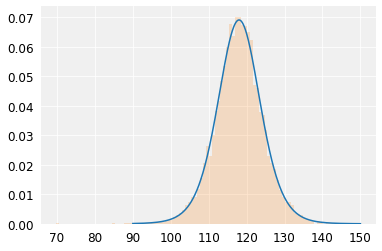

In [11]:
plt.plot(t1, pm_mu)
_=plt.hist(mu, bins=100, alpha=0.2, density=True)

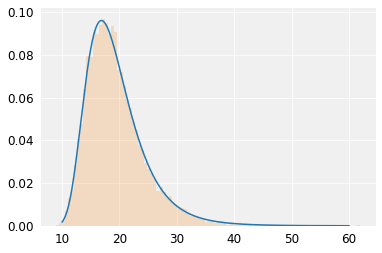

In [12]:
#exact calculation for sigma
tl2 = [10, 60]
t2 = np.linspace(tl2[0], tl2[1], 1000)
pm_sigma = sinvchi2.pdf(t2**2, n-1, s2)*2*t2

plt.plot(t2, pm_sigma)
_=plt.hist(sigma, bins=100, density=True, alpha=0.2)

In [13]:
# evaluate the joint density in a grid
# note that the following is not normalized, but for plotting
# contours it does not matter
Z = stats.norm.pdf(t1, my, t2[:,np.newaxis]/np.sqrt(n))
Z *= (sinvchi2.pdf(t2**2, n-1, s2)*2*t2)[:,np.newaxis]
Z.shape

(1000, 1000)

Text(30.0, 0.5, 'Sigma')

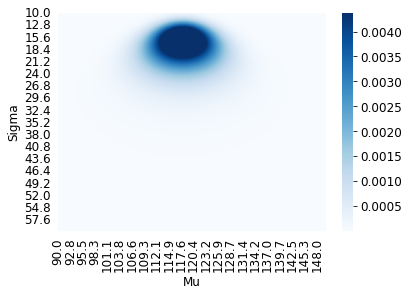

In [14]:
df_z=pd.DataFrame(Z)
df_z.index=t2.round(1)
df_z.columns=t1.round(1)
ax=sns.heatmap(df_z, cmap='Blues', robust=True)

plt.xlabel('Mu')
plt.ylabel('Sigma')

## Bioassay example

In [15]:
# seed a random state
rng = np.random.RandomState(0)

In [16]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

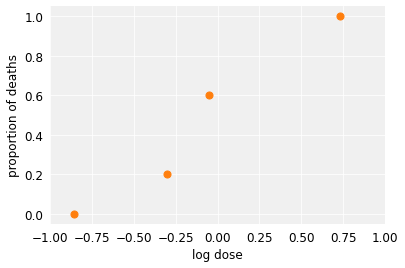

In [17]:
# plot the data
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

In [18]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
A = np.linspace(-4, 8, 100)
B = np.linspace(-10, 40, 100)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

In [19]:
p.shape

(100, 100)

Text(30.0, 0.5, 'alpha')

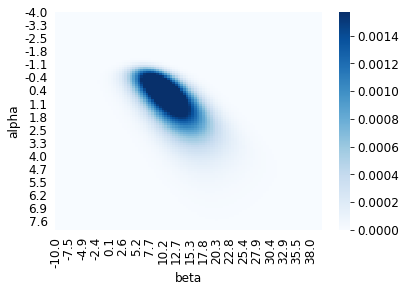

In [20]:
df_p=pd.DataFrame(p)
df_p.index=A.round(1)
df_p.columns=B.round(1)

ax=sns.heatmap(df_p, cmap='Blues', robust=True)
plt.xlabel('beta')
plt.ylabel('alpha')

In [21]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (rng.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (rng.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]

In [22]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt)

Text(0, 0.5, 'proportion of deaths')

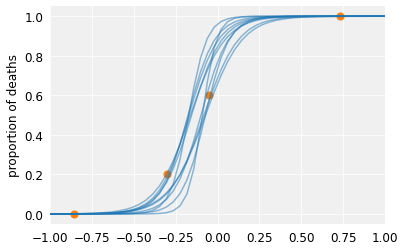

In [23]:
ax=plt.plot(xt, fs[:10].T, color='C0', alpha=0.5)
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.ylabel('proportion of deaths')